In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import intake,yaml
import intake_esm
from scipy import special
import keras
from keras.models import Model
from keras.layers import Dense, Input

In [2]:
def latest_version(cat):
    """
    input
    cat: esmdatastore
    output
    esmdatastore with latest DRS versions
    """
    latest_cat = cat.df.sort_values(by=['version','path']).drop_duplicates(['temporal_subset','source_id','table_id',
                                               'institution_id','variable_id','member_id',
                                               'grid_label','experiment_id'],keep='last')
    return latest_cat

In [3]:
#col_url = "https://cmip6-nc.s3.us-east-2.amazonaws.com/esgf-world.json" 
col_url = "https://raw.githubusercontent.com/aradhakrishnanGFDL/gfdl-aws-analysis/master/esm-collection-spec-examples/esgf-world.json"
col = intake.open_esm_datastore(col_url)
esmcol_data = col.esmcol_data

In [4]:
model_name = 'IPSL-CM6A-LR'

In [5]:
#mlotst, tos,uo,vo

In [6]:
def chunk_time(ds):
    if 'time' in ds.dims:
        ds = ds.chunk({'time':1})
    return ds

In [7]:
# Necessary for creating a common time axis for all models
# We want to create a common time axis so there will be no gaps when plotting the results 

def fix_time(ds):
    """ force calendar to noleap"""
    import xarray as xr
    
    if "time" not in ds.dims:
        return ds
    
    if ("calendar" not in ds["time"].attrs): 
        ds["time"].attrs.update({"calendar": "noleap"})
        
    if ds["time"].attrs["calendar"] not in ["noleap", "NOLEAP", "365_day"]:
        ds["time"].attrs.update({"calendar": "noleap"})
        
    ds = xr.decode_cf(ds)
    return ds

In [8]:
def pp_enso(ds):
    ds = ds.copy()   #the wrapper function makes a copy of the ds and works from this
    #ds = rename_cmip6(ds)
    ds = fix_time(ds)
    #ds = fix_units(ds)
    #ds = correct_units(ds)
    return ds

In [9]:
#tos_ sea surface temperature
#area cello
#ofx ocean fixed
#omon  ocean monthly average 

In [10]:

query_Omon_tos = dict(experiment_id=['abrupt-4xCO2','1pctCO2','historical'],
                 table_id=['Omon'],
                 member_id=["r1i1p1f1","r1i1p1f2"],
                 source_id=model_name,
                 grid_label=['gn'],
                 variable_id=["tos"])
query_Ofx = dict(experiment_id=['abrupt-4xCO2','1pctCO2','historical'],
                 table_id=['Ofx'],
               member_id=["r1i1p1f1","r1i1p1f2"],
                 source_id=model_name,
                 grid_label=['gn'],
                 variable_id=["areacello"])

In [11]:
cat_Omon_tos = col.search(**query_Omon_tos)
cat_Omon_tos_lat = latest_version(cat_Omon_tos)

cat_Omon_tos_latest = intake.open_esm_datastore(cat_Omon_tos_lat,esmcol_data=esmcol_data)

In [12]:
cat_Omon_tos_latest.df

,project,institution_id,source_id,experiment_id,frequency,modeling_realm,table_id,member_id,grid_label,variable_id,temporal_subset,version,path
0,CMIP6,IPSL,IPSL-CM6A-LR,1pctCO2,mon,ocean,Omon,r1i1p1f1,gn,tos,185001-199912,v20180727,s3://esgf-world/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/1...
7,CMIP6,IPSL,IPSL-CM6A-LR,historical,mon,ocean,Omon,r1i1p1f1,gn,tos,185001-201412,v20180803,s3://esgf-world/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/h...
4,CMIP6,IPSL,IPSL-CM6A-LR,abrupt-4xCO2,mon,ocean,Omon,r1i1p1f1,gn,tos,185001-214912,v20190118,s3://esgf-world/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/a...
5,CMIP6,IPSL,IPSL-CM6A-LR,abrupt-4xCO2,mon,ocean,Omon,r1i1p1f1,gn,tos,215001-244912,v20190118,s3://esgf-world/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/a...
6,CMIP6,IPSL,IPSL-CM6A-LR,abrupt-4xCO2,mon,ocean,Omon,r1i1p1f1,gn,tos,245001-274912,v20190118,s3://esgf-world/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/a...


In [13]:
cat_Ofx = col.search(**query_Ofx)
cat_Ofx_lat = latest_version(cat_Ofx)

cat_Ofx_latest = intake.open_esm_datastore(cat_Ofx_lat,esmcol_data=esmcol_data)

In [14]:
cat_Ofx_latest.df

,project,institution_id,source_id,experiment_id,frequency,modeling_realm,table_id,member_id,grid_label,variable_id,temporal_subset,version,path
0,CMIP6,IPSL,IPSL-CM6A-LR,1pctCO2,NaN,NaN,Ofx,r1i1p1f1,gn,areacello,NaN,v20180727,s3://esgf-world/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/1...
4,CMIP6,IPSL,IPSL-CM6A-LR,historical,NaN,NaN,Ofx,r1i1p1f1,gn,areacello,NaN,v20180803,s3://esgf-world/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/h...
3,CMIP6,IPSL,IPSL-CM6A-LR,abrupt-4xCO2,NaN,NaN,Ofx,r1i1p1f1,gn,areacello,NaN,v20190118,s3://esgf-world/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/a...


In [15]:
dict_Omon_tos = cat_Omon_tos_latest.to_dataset_dict(storage_options=dict(anon=True), cdf_kwargs={'decode_times': False,'chunks': {'time': 1}}, preprocess = pp_enso)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institution_id.source_id.experiment_id.table_id'


In [16]:
dict_Ofx = cat_Ofx_latest.to_dataset_dict(storage_options=dict(anon=True),cdf_kwargs={'decode_times': True,'chunks': {}})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institution_id.source_id.experiment_id.table_id'


In [17]:
dict_Omon_tos.keys()

dict_keys(['CMIP6.IPSL.IPSL-CM6A-LR.1pctCO2.Omon', 'CMIP6.IPSL.IPSL-CM6A-LR.historical.Omon', 'CMIP6.IPSL.IPSL-CM6A-LR.abrupt-4xCO2.Omon'])

In [18]:
dict_Ofx.keys()

dict_keys(['CMIP6.IPSL.IPSL-CM6A-LR.abrupt-4xCO2.Ofx', 'CMIP6.IPSL.IPSL-CM6A-LR.historical.Ofx', 'CMIP6.IPSL.IPSL-CM6A-LR.1pctCO2.Ofx'])

In [19]:
ds_Ofx = dict_Ofx["CMIP6.IPSL.IPSL-CM6A-LR.historical.Ofx"] #xarray dataset object to access Ofx areacello dataset used to calculate the weighted average

In [20]:
def distance_on_unit_sphere(lat1, long1, lat2, long2):

    # Convert latitude and longitude to
    # spherical coordinates in radians.
    degrees_to_radians = np.pi / 180.0

    # phi = 90 - latitude
    phi1 = (90.0 - lat1) * degrees_to_radians
    phi2 = (90.0 - lat2) * degrees_to_radians

    # theta = longitude
    theta1 = long1 * degrees_to_radians
    theta2 = long2 * degrees_to_radians
    # Compute spherical distance from spherical coordinates.
    # For two locations in spherical coordinates
    # (1, theta, phi) and (1, theta, phi)
    # cosine( arc length ) =
    #    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length
    cos = np.sin(phi1) * np.sin(phi2) * np.cos(theta1 - theta2) + np.cos(phi1) * np.cos(
        phi2
    )
    arc = np.arccos(cos)
    # Remember to multiply arc by the radius of the earth
    # in your favorite set of units to get length.
    return arc

In [21]:
def find_closest_grid_point(lon, lat, gridlon, gridlat):
    """find integer indices of closest grid point in grid of coordinates
    gridlon, gridlat for a given geographical lon/lat.
    PARAMETERS:
    -----------
        lon (float): longitude of point to find
        lat (float): latitude of point to find
        gridlon (numpy.ndarray): grid longitudes
        gridlat (numpy.ndarray): grid latitudes
    RETURNS:
    --------
    iclose, jclose: integer
        grid indices for geographical point of interest
    """

    if isinstance(gridlon, xr.core.dataarray.DataArray):
        gridlon = gridlon.values
    if isinstance(gridlat, xr.core.dataarray.DataArray):
        gridlat = gridlat.values
    dist = distance_on_unit_sphere(lat, lon, gridlat, gridlon)
    jclose, iclose = np.unravel_index(dist.argmin(), gridlon.shape)
    return iclose, jclose


In [23]:
i,j= find_closest_grid_point(-157, -5, ds_Ofx.nav_lon, ds_Ofx.nav_lat)#for southwest
i,j

(130, 171)

In [24]:
k,l = find_closest_grid_point(-90, 5, ds_Ofx.nav_lon, ds_Ofx.nav_lat)#for northwest
k,l

(197, 201)

CALCULATING the summation of areacello

In [25]:
#TODO INSERT CELL SELECT region of interest in areacello
areacello_nino3 = ds_Ofx.areacello.sel(y = slice(j,l), x = slice(i,k))

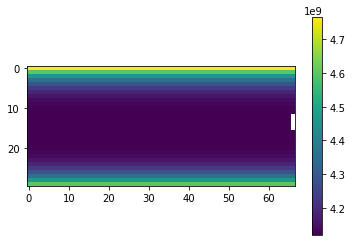

In [26]:
plt.imshow(areacello_nino3[0])
plt.colorbar()

In [27]:
#TODO 
#CALCULATE total_areacello, summation across lat,lon (in our dataset y,x respectively)

total_areacello = areacello_nino3.sum(dim=('x', 'y'))


NINO3 INDEX CALCULATION 

REGION 

(5S-5N , 150W-90W) 

SELECT tos and areacello for the region of interest

## Historical

In [28]:
ds_hist = dict_Omon_tos["CMIP6.IPSL.IPSL-CM6A-LR.historical.Omon"]


In [29]:
ds_hist.time.to_dataframe()

,time
time,
1850-01-16 12:00:00,1850-01-16 12:00:00
1850-02-15 00:00:00,1850-02-15 00:00:00
1850-03-16 12:00:00,1850-03-16 12:00:00
1850-04-16 00:00:00,1850-04-16 00:00:00
1850-05-16 12:00:00,1850-05-16 12:00:00
...,...
2014-09-25 12:00:00,2014-09-25 12:00:00
2014-10-26 00:00:00,2014-10-26 00:00:00
2014-11-25 12:00:00,2014-11-25 12:00:00


In [30]:
tm_his_st, tm_his_nd = '1980','2011'

In [31]:
tos_his = ds_hist.tos.sel(y = slice(j,l), x = slice(i,k), time = slice(tm_his_st, tm_his_nd))
tos_his

<xarray.DataArray 'tos' (member_id: 1, time: 384, y: 30, x: 67)>
dask.array<getitem, shape=(1, 384, 30, 67), dtype=float32, chunksize=(1, 1, 30, 67), chunktype=numpy.ndarray>
Coordinates:
    nav_lat    (y, x) float32 dask.array<chunksize=(30, 67), meta=np.ndarray>
    nav_lon    (y, x) float32 dask.array<chunksize=(30, 67), meta=np.ndarray>
  * time       (time) object 1980-01-16 12:00:00 ... 2011-12-25 00:00:00
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_surface_temperature
    long_name:           Sea Surface Temperature
    units:               degC
    online_operation:    average
    cell_methods:        area: mean where sea time: mean
    interval_operation:  2700 s
    interval_write:      1 month
    cell_measures:       area: areacello
    description:         This may differ from "surface temperature" in region...
    history:             none

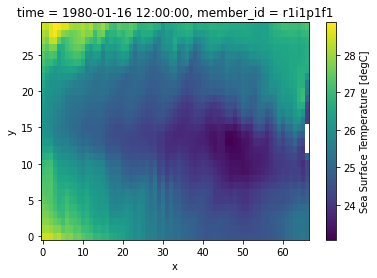

In [32]:
tos_his.isel(time=0).plot()


CALCULATE SEA SURFACE TEMPERATURE WEIGHTED AVERAGE

In [33]:
tos_mean_nino3_his = (tos_his * areacello_nino3).sum(dim=('x', 'y')) / total_areacello
#nino3_index.plot()

In [34]:
tos_mean_nino3_his = tos_mean_nino3_his.compute()

In [35]:
tos_mean_nino3_his.size #1980 values, 1 value per month , 12 per year for 165 years

384

In [36]:
tos_mean_nino3_his.isel(time=0).compute()

<xarray.DataArray (member_id: 1)>
array([25.320503], dtype=float32)
Coordinates:
    time       object 1980-01-16 12:00:00
  * member_id  (member_id) <U8 'r1i1p1f1'

In [37]:
datetimeindex = tos_mean_nino3_his.indexes['time'].to_datetimeindex()
tos_mean_nino3_his['time'] = datetimeindex


<ipython-input-37-e7b25880c2d7>:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = tos_mean_nino3_his.indexes['time'].to_datetimeindex()


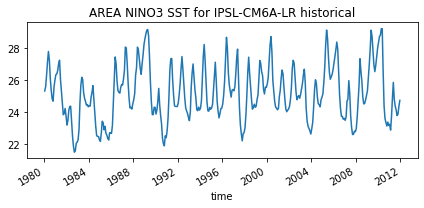

In [38]:
tos_mean_nino3_his.sel(time=slice(tm_his_st, tm_his_nd)).plot(aspect=2, size=3)
plt.title(f"AREA NINO3 SST for {model_name} historical")
plt.tight_layout()
plt.draw()
plt.savefig(f"{model_name}_SST_Hist_{tm_his_st}_{tm_his_nd}.png")

ADDITIONAL EXPLORATION

CLIMATOLOGY (average all Jans, Febs, etc) CALC EXAMPLES (YEARS NEED A TWEAK, calculate for 20 year chunks or as needed)

In [39]:
tos_nino3_climatology = tos_mean_nino3_his.sel(time=slice("1980", "2011")).groupby('time.day').mean(dim='time')


In [40]:
tos_nino3_climatology = tos_nino3_climatology.compute()

In [42]:
#tos_nino3_climatology.isel(day=0).plot()
print(tos_nino3_climatology)

<xarray.DataArray (member_id: 1, day: 11)>
array([[25.455967, 24.57416 , 24.527891, 25.047216, 25.153353, 25.37226 ,
        25.276804, 25.249405, 25.50301 , 25.884226, 26.506897]],
      dtype=float32)
Coordinates:
  * member_id  (member_id) <U8 'r1i1p1f1'
  * day        (day) int64 16 17 18 19 20 21 22 23 24 25 26


monthly anomaly of SST (or TOS here) over the Nino3 region

we subtract the monthly climatology values calculated above from the TOS value values and then do
a spatial average across the region of interest

In [145]:
tos_sel = tos_his.sel(time=slice('1980','2011'))
index_nino3 = (tos_sel.groupby('time.day')-tos_nino3_climatology).mean(dim=['x','y'])

In [146]:
index_nino3.compute()

/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'tos' (member_id: 1, time: 384)>
array([[-1.35181084e-01,  1.35181114e-01,  1.80445600e+00,
         2.56956124e+00,  3.28258705e+00,  2.68435025e+00,
         1.57839370e+00,  7.90716231e-01,  2.51117229e-01,
         1.52186841e-01,  1.00132120e+00,  1.49123335e+00,
         1.78132772e+00,  1.83214188e+00,  1.56761658e+00,
         2.45996237e+00,  2.72879148e+00,  1.47600508e+00,
         7.90786564e-01,  6.42222837e-02, -7.46752143e-01,
        -6.29533172e-01, -3.48024309e-01, -7.87495792e-01,
        -1.40119243e+00, -1.10336947e+00, -9.45914805e-01,
        -2.46467382e-01, -1.83425248e-01, -1.15887296e+00,
        -2.05342674e+00, -2.73854327e+00, -3.11170006e+00,
        -2.96968246e+00, -2.53736496e+00, -2.43563652e+00,
        -2.32261968e+00, -1.64966643e+00, -4.49074686e-01,
         1.09321475e+00,  1.64579844e+00,  1.45242107e+00,
         6.82906568e-01,  2.98154294e-01,  9.69066694e-02,
        -8.95437002e-02, -1.00933298e-01, -1.98621690e-01,
        -1.83804601e-01, -2.02112228e-01, -1.04314290e-01,
         6.97762012e-01,  6.01688564e-01,  2.34245807e-01,
        -1.19569588e+00, -1.43575382e+00, -2.02291393e+00,
        -2.58074498e+00, -2.07230067e+00, -2.80682421e+00,
...
        -1.77963614e+00, -1.58075476e+00, -1.21353126e+00,
        -4.74525750e-01,  4.58609551e-01, -1.11626655e-01,
        -1.75712645e+00, -2.23527265e+00, -2.66932535e+00,
        -2.90933108e+00, -2.45444298e+00, -2.74750853e+00,
        -2.29106832e+00, -1.56137776e+00, -1.23277867e+00,
         1.86421990e-01,  1.46902776e+00,  1.05770314e+00,
         5.81351779e-02, -5.40212154e-01, -9.87446487e-01,
        -1.34370172e+00, -7.46981561e-01, -8.37521613e-01,
        -1.60599545e-01,  6.88125372e-01,  4.91532236e-01,
         2.44245791e+00,  3.27768183e+00,  3.28544545e+00,
         2.00774050e+00,  1.47500467e+00,  1.04315889e+00,
         1.05747402e+00,  2.00144172e+00,  2.14376545e+00,
         2.89784646e+00,  3.27175856e+00,  2.33833385e+00,
         3.74721813e+00,  3.37716985e+00,  1.03177142e+00,
        -1.54601109e+00, -1.93237305e+00, -2.18420291e+00,
        -2.78120613e+00, -2.14098001e+00, -2.74293470e+00,
        -2.27963805e+00, -2.65568566e+00, -2.82986617e+00,
        -6.86338067e-01, -3.38239893e-02, -7.14770854e-01,
        -1.51463437e+00, -1.36182821e+00, -1.72834551e+00,
        -2.00829434e+00, -1.13800395e+00, -1.14820933e+00]], dtype=float32)
Coordinates:
  * time       (time) object 1980-01-16 12:00:00 ... 2011-12-25 00:00:00
  * member_id  (member_id) <U8 'r1i1p1f1'
    day        (time) int64 16 16 18 17 18 17 18 17 ... 25 24 25 24 24 25 24 25

<ipython-input-147-90fd70a17ab6>:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = index_nino3.indexes['time'].to_datetimeindex()


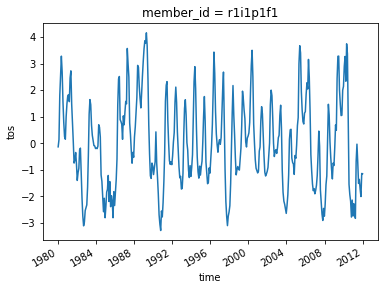

In [147]:
datetimeindex = index_nino3.indexes['time'].to_datetimeindex()
index_nino3['time'] = datetimeindex
index_nino3.plot()

## 1%CO2

In [32]:
ds_1pct = dict_Omon_tos["CMIP6.NOAA-GFDL.GFDL-ESM4.1pctCO2.Omon"]

In [33]:
ds_1pct.time.to_dataframe()

,time
time,
0001-01-16 12:00:00,0001-01-16 12:00:00
0001-02-15 00:00:00,0001-02-15 00:00:00
0001-03-16 12:00:00,0001-03-16 12:00:00
0001-04-16 00:00:00,0001-04-16 00:00:00
0001-05-16 12:00:00,0001-05-16 12:00:00
...,...
0150-08-16 12:00:00,0150-08-16 12:00:00
0150-09-16 00:00:00,0150-09-16 00:00:00
0150-10-16 12:00:00,0150-10-16 12:00:00


In [ ]:
#ds_1pct.info


In [20]:
#tos_1pct = ds_1pct.tos#.sel(time = slice("1980", "2011"))

In [34]:
#TODO INSERT CORRECT CODE TO SELECT SPECIFIED REGION (lat range and lon range) in TOS 

tos_1pct = ds_1pct.tos.sel(y = slice(-5,5), x = slice(-150,-90))
#tos

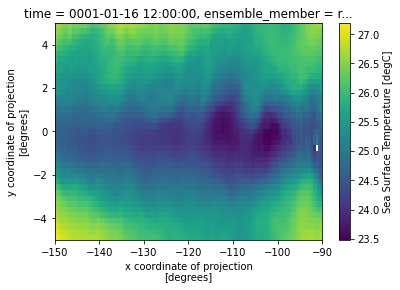

In [35]:
tos_1pct.isel(time=0).plot()

CALCULATE SEA SURFACE TEMPERATURE WEIGHTED AVERAGE

In [36]:
tos_mean_nino3_1pct = (tos_1pct * areacello_nino3).sum(dim=('x', 'y')) / total_areacello
#nino3_index.plot()

In [37]:
tos_mean_nino3_1pct.compute()

<xarray.DataArray (ensemble_member: 1, time: 1800)>
array([[25.240553, 25.748297, 26.135637, ..., 27.92831 , 28.12126 ,
        28.985657]], dtype=float32)
Coordinates:
  * time             (time) object 0001-01-16 12:00:00 ... 0150-12-16 12:00:00
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'

In [38]:
tos_mean_nino3_1pct.size

1800

In [39]:
tos_mean_nino3_1pct.isel(time=0).compute()

<xarray.DataArray (ensemble_member: 1)>
array([25.240553], dtype=float32)
Coordinates:
    time             object 0001-01-16 12:00:00
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'

In [40]:
#datetimeindex_1pct = tos_mean_nino3_1pct.indexes['time'].to_datetimeindex()

In [41]:
#tos_mean_nino3_1pct['time'] = datetimeindex_1pct

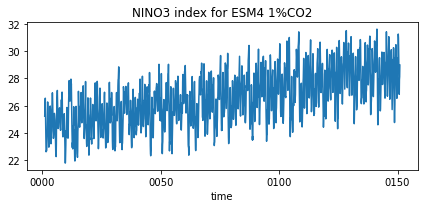

In [42]:
tos_mean_nino3_1pct.plot(aspect=2, size=3)
plt.title("NINO3 index for ESM4 1%CO2")
plt.tight_layout()
plt.draw()

In [43]:
tos_nino3_climatology_1pct = tos_1pct.sel(time=slice('0119','0150')).groupby('time.month').mean(dim='time')


In [44]:
tos_nino3_climatology_1pct.compute()

/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'tos' (ensemble_member: 1, month: 12, y: 39, x: 120)>
array([[[[30.213112, 30.188995, 30.1706  , ..., 29.830112, 29.852398,
          29.880331],
         [30.17844 , 30.152851, 30.136745, ..., 29.842587, 29.863445,
          29.887173],
         [30.136904, 30.104893, 30.091488, ..., 29.851913, 29.86638 ,
          29.886084],
         ...,
         [29.589394, 29.584965, 29.576187, ..., 29.719463, 29.811716,
          29.888096],
         [29.638636, 29.631884, 29.618332, ..., 29.712002, 29.81858 ,
          29.911   ],
         [29.680494, 29.672598, 29.662003, ..., 29.687664, 29.81202 ,
          29.919664]],

        [[30.676498, 30.66817 , 30.655128, ..., 30.525711, 30.507595,
          30.491983],
         [30.614304, 30.60513 , 30.58675 , ..., 30.50057 , 30.467339,
          30.447266],
         [30.538797, 30.530914, 30.518574, ..., 30.438341, 30.40107 ,
          30.376741],
...
         [29.544744, 29.53453 , 29.50552 , ..., 30.165003, 30.139393,
          30.10944 ],
         [29.634571, 29.615286, 29.59287 , ..., 30.202045, 30.17641 ,
          30.1494  ],
         [29.734144, 29.716854, 29.695312, ..., 30.223364, 30.201542,
          30.186283]],

        [[29.6629  , 29.649364, 29.6409  , ..., 27.941244, 27.945028,
          27.946358],
         [29.628082, 29.61208 , 29.59947 , ..., 27.912395, 27.917028,
          27.923817],
         [29.5962  , 29.581236, 29.560741, ..., 27.876083, 27.887657,
          27.897982],
         ...,
         [29.644798, 29.61794 , 29.590204, ..., 29.97118 , 30.009048,
          30.051731],
         [29.711823, 29.680387, 29.655628, ..., 29.95771 , 30.007977,
          30.058826],
         [29.765667, 29.735834, 29.713638, ..., 29.922577, 29.986296,
          30.047022]]]], dtype=float32)
Coordinates:
    lat              (y, x) float32 -4.872 -4.872 -4.872 ... 4.872 4.872 4.872
    lon              (y, x) float32 -149.8 -149.2 -148.8 ... -90.75 -90.25
  * x                (x) float64 -149.8 -149.2 -148.8 ... -91.25 -90.75 -90.25
  * y                (y) float64 -4.872 -4.615 -4.359 ... 4.359 4.615 4.872
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'
  * month            (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

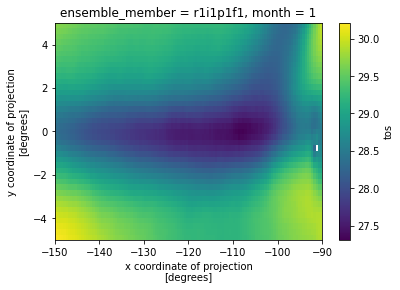

In [45]:
tos_nino3_climatology_1pct.isel(month=0).plot()

monthly anomaly of SST (or TOS here) over the Nino3 region

we subtract the monthly climatology values calculated above from the TOS value values and then do
a spatial average across the region of interest

In [46]:
tos_sel = tos_1pct.sel(time=slice('0119','0150'))
index_nino3 = (tos_sel.groupby('time.month')-tos_nino3_climatology_1pct).mean(dim=['x','y'])

In [47]:
index_nino3.compute()

/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'tos' (ensemble_member: 1, time: 384)>
array([[-2.4369519 , -2.2268212 , -1.0887513 , -1.6543334 , -1.5035197 ,
        -1.2875879 , -1.0684881 , -1.4005944 , -1.2731    , -1.3996809 ,
        -1.58933   , -1.5726931 , -1.2612725 , -0.6119959 , -0.51061875,
        -0.13067307, -0.29454368, -0.04160992, -0.17284419, -0.26489195,
         0.02869011,  0.4207879 ,  0.02471487, -0.04387553, -0.07532196,
        -0.19544934, -0.26992562, -0.8190028 , -0.30284485, -0.6764676 ,
        -0.6333329 , -0.01547616,  0.16490395, -0.28924665, -0.644857  ,
        -0.14059876, -0.39786774, -0.26563781, -0.53002644, -0.5272849 ,
         0.02802673,  0.98940456,  1.3593884 ,  0.9912849 ,  0.66672784,
         0.670518  ,  0.30287465, -0.25085023, -0.26936194, -0.45564312,
        -0.80144507, -0.38800552, -0.9126912 , -1.1749899 , -1.3568214 ,
        -1.1087555 , -1.4447093 , -0.64234054, -0.5694114 , -0.77251536,
        -0.32780448, -0.8955987 , -0.01791439,  0.02088269, -0.28242624,
        -0.93562704, -1.3307865 , -1.9477749 , -1.9943852 , -1.7336345 ,
        -2.2079718 , -1.6415415 , -0.68658674, -0.3762771 ,  0.16121095,
         0.091989  ,  0.7316947 ,  1.1050764 ,  0.9559299 ,  0.6947481 ,
         0.6008345 ,  0.18342237, -0.06635599, -0.5096147 , -0.6080536 ,
        -1.1362656 , -1.2539004 , -0.6717468 , -1.4990873 , -1.2803187 ,
        -0.61892086, -0.31274074, -0.18638737, -0.02652749,  0.4875758 ,
         0.6004967 ,  0.2831006 ,  0.27150095,  0.58753574,  0.36027732,
...
        -0.5345194 , -0.53313386, -0.11180329,  0.26588023,  0.3369079 ,
         0.82470024,  1.2793261 ,  1.2823577 ,  0.91595846,  0.5875596 ,
         0.38317513,  0.21429671, -0.31416753, -0.35331574, -0.46565187,
        -0.8663356 , -0.64976525, -0.03015177,  0.24542378,  0.1765754 ,
         0.32983452,  0.50830954,  0.43352586,  0.35982594,  0.9267963 ,
         1.157785  ,  0.6227679 ,  0.6827985 ,  0.75364524,  0.62893903,
         0.38742086,  0.3754449 ,  0.32459682,  0.33483157,  0.20203443,
         0.9881769 ,  0.9853196 ,  0.7987803 ,  0.51569223,  0.95085263,
         0.9769161 ,  0.82514256,  0.1648155 , -0.13554479,  0.08262371,
        -0.27564645,  0.07859372,  0.19080994, -0.4583548 , -0.316397  ,
         0.06270322, -0.03229918, -0.11438977, -0.47512197, -0.5908516 ,
        -0.17773159, -0.04202524,  0.08589452,  0.09709202,  0.50927603,
        -0.35982484, -0.00820339,  0.06509932, -0.5364282 , -0.7249427 ,
        -1.2470423 , -1.5404854 , -1.21077   , -1.1435374 , -0.4587622 ,
         0.7545023 ,  0.3829307 ,  0.41256016,  0.2119426 ,  0.28851348,
        -0.11456998, -0.08851116,  0.24047692,  0.23467404,  0.10117027,
         0.38907775,  0.3508126 ,  0.75314975,  0.10327009,  0.20809744,
         0.99135965,  0.91818434,  1.1799519 ,  1.1277878 ,  0.99605316,
         0.5242531 ,  1.2069478 ,  0.84775275,  0.85939485]],
      dtype=float32)
Coordinates:
  * time             (time) object 0119-01-16 12:00:00 ... 0150-12-16 12:00:00
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'
    month            (time) int64 1 2 3 4 5 6 7 8 9 10 ... 4 5 6 7 8 9 10 11 12

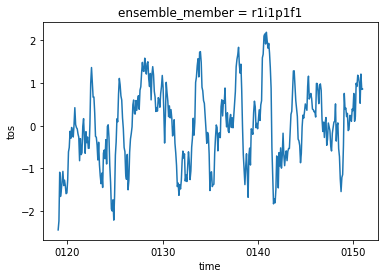

In [48]:
#datetimeindex = index_nino3.indexes['time'].to_datetimeindex()
#index_nino3['time'] = datetimeindex
index_nino3.plot()

## Abrupt-4xCO2

In [49]:
ds_4x = dict_Omon_tos["CMIP6.NOAA-GFDL.GFDL-ESM4.abrupt-4xCO2.Omon"]

In [50]:
ds_4x.time.to_dataframe()

,time
time,
0001-01-16 12:00:00,0001-01-16 12:00:00
0001-02-15 00:00:00,0001-02-15 00:00:00
0001-03-16 12:00:00,0001-03-16 12:00:00
0001-04-16 00:00:00,0001-04-16 00:00:00
0001-05-16 12:00:00,0001-05-16 12:00:00
...,...
0150-08-16 12:00:00,0150-08-16 12:00:00
0150-09-16 00:00:00,0150-09-16 00:00:00
0150-10-16 12:00:00,0150-10-16 12:00:00


In [51]:
tos_4x = ds_4x.tos.sel(time = slice("0119", "0150"))

In [52]:
#TODO INSERT CORRECT CODE TO SELECT SPECIFIED REGION (lat range and lon range) in TOS 
#tos = ds.tos......
tos_4x = ds_4x.tos.sel(y = slice(-5,5), x = slice(-150,-90))
#tos

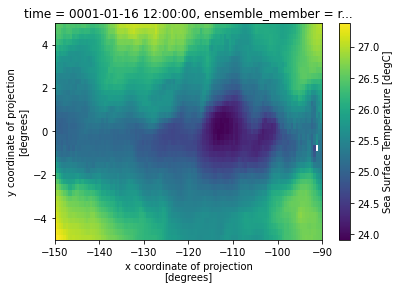

In [53]:
tos_4x.isel(time=0).plot()

CALCULATE SEA SURFACE TEMPERATURE WEIGHTED AVERAGE

In [54]:
tos_mean_nino3_4x = (tos_4x * areacello_nino3).sum(dim=('x', 'y')) / total_areacello
#nino3_index.plot()

In [55]:
tos_mean_nino3_4x.compute()

<xarray.DataArray (ensemble_member: 1, time: 1800)>
array([[25.639414, 26.249512, 26.237864, ..., 26.837673, 27.146858,
        28.272776]], dtype=float32)
Coordinates:
  * time             (time) object 0001-01-16 12:00:00 ... 0150-12-16 12:00:00
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'

In [56]:
tos_mean_nino3_4x.size #1980 values, 1 value per month , 12 per year for 165 years

1800

In [57]:
tos_mean_nino3_4x.isel(time=0).compute()

<xarray.DataArray (ensemble_member: 1)>
array([25.639414], dtype=float32)
Coordinates:
    time             object 0001-01-16 12:00:00
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'

In [ ]:
#datetimeindex_4x = tos_mean_nino3_4x.indexes['time'].to_datetimeindex()
#tos_mean_nino3_4x['time'] = datetimeindex_4x


In [ ]:
tos_mean_nino3_4x.sel(time=slice('0119','0150')).plot(aspect=2, size=3)
plt.title("NINO3 index for ESM4 abrupt-4xCO2")
plt.tight_layout()
plt.draw()

In [ ]:
tos_nino3_climatology_4x = tos_4x.sel(time=slice('0119','0150')).groupby('time.month').mean(dim='time')


In [ ]:
tos_nino3_climatology_4x.compute()

In [ ]:
tos_nino3_climatology_4x.isel(month=0).plot()

monthly anomaly of SST (or TOS here) over the Nino3 region

we subtract the monthly climatology values calculated above from the TOS value values and then do
a spatial average across the region of interest

In [46]:
tos_sel_4x = tos_4x.sel(time=slice('0119','0150'))
index_nino3_4x = (tos_sel_4x.groupby('time.month')-tos_nino3_climatology_4x).mean(dim=['x','y'])

In [ ]:
index_nino3_4x.compute()

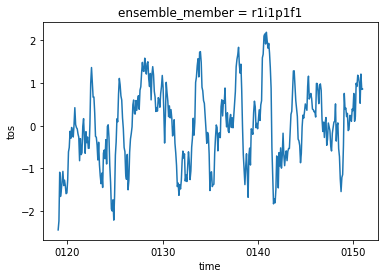

In [48]:
#datetimeindex = index_nino3.indexes['time'].to_datetimeindex()
#index_nino3['time'] = datetimeindex
index_nino3_4x.plot()